In [1]:
%%capture
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases #Package for database reading.

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.manifold import TSNE
from scipy.signal import freqz, filtfilt, resample
from scipy.signal import butter as bw
from scipy.stats import entropy

from gcpds.databases import GIGA_MI_ME

In [3]:
path = '/kaggle/input/giga-science-gcpds/GIGA_MI_ME/metadata/Questionnaire_results_of_52_subjects.xlsx'

threshold = 1.0546970453123818

dataframe = pandas.read_excel(path, )
dataframe.loc[10, 's23'] = 0
dataframe.loc[10, 's23']

0.0

In [4]:
def butterworth_digital_filter(X, N, Wn, btype, fs, axis=-1, padtype=None, padlen=0, method='pad', irlen=None):
  """
  Apply digital butterworth filter
  INPUT
  ------
  1. X: (D array)
    array with signals.
  2. N: (int+)
    The order of the filter.
  3. Wn: (float+ or 1D array)
    The critical frequency or frequencies. For lowpass and highpass filters, Wn is a scalar; for bandpass and bandstop filters, Wn is a length-2 vector.
    For a Butterworth filter, this is the point at which the gain drops to 1/sqrt(2) that of the passband (the “-3 dB point”).
    If fs is not specified, Wn units are normalized from 0 to 1, where 1 is the Nyquist frequency (Wn is thus in half cycles / sample and defined as 2*critical frequencies / fs). If fs is specified, Wn is in the same units as fs.
  4. btype: (str) {‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}
    The type of filter
  5. fs: (float+)
    The sampling frequency of the digital system.
  6. axis: (int), Default=1.
    The axis of x to which the filter is applied.
  7. padtype: (str) or None, {'odd', 'even', 'constant'}
    This determines the type of extension to use for the padded signal to which the filter is applied. If padtype is None, no padding is used. The default is ‘odd’.
  8. padlen: (int+) or None, Default=0
    The number of elements by which to extend x at both ends of axis before applying the filter. This value must be less than x.shape[axis] - 1. padlen=0 implies no padding.
  9. method: (str), {'pad', 'gust'}
    Determines the method for handling the edges of the signal, either “pad” or “gust”. When method is “pad”, the signal is padded; the type of padding is determined by padtype
    and padlen, and irlen is ignored. When method is “gust”, Gustafsson’s method is used, and padtype and padlen are ignored.
  10. irlen: (int) or None, Default=nONE
    When method is “gust”, irlen specifies the length of the impulse response of the filter. If irlen is None, no part of the impulse response is ignored.
    For a long signal, specifying irlen can significantly improve the performance of the filter.
  OUTPUT
  ------
  X_fil: (D array)
    array with filtered signals.
  """
  b, a = bw(N, Wn, btype, analog=False, output='ba', fs=fs)
  return filtfilt(b, a, X, axis=axis, padtype=padtype, padlen=padlen, method=method, irlen=irlen)

class TimeFrequencyRpr(BaseEstimator, TransformerMixin):
  """
  Time frequency representation of EEG signals.

  Parameters
  ----------
    1. sfreq:  (float) Sampling frequency in Hz.
    2. f_bank: (2D array) Filter banks Frequencies. Default=None
    3. vwt:    (2D array) Interest time windows. Default=None
  Methods
  -------
    1. fit(X, y=None)
    2. transform(X, y=None)
  """
  def __init__(self, sfreq, f_bank=None, vwt=None):
    self.sfreq = sfreq
    self.f_bank = f_bank
    self.vwt = vwt
# ------------------------------------------------------------------------------

  def _validation_param(self):
    """
    Validate Time-Frequency characterization parameters.
    INPUT
    -----
      1. self
    ------
      2. None
    """
    if self.sfreq <= 0:
      raise ValueError('Non negative sampling frequency is accepted')


    if self.f_bank is None:
      self.flag_f_bank = False
    elif self.f_bank.ndim != 2:
      raise ValueError('Band frequencies have to be a 2D array')
    else:
      self.flag_f_bank = True

    if self.vwt is None:
      self.flag_vwt = False
    elif self.vwt.ndim != 2:
      raise ValueError('Time windows have to be a 2D array')
    else:
      self.flag_vwt = True

# ------------------------------------------------------------------------------
  def _filter_bank(self, X):
    """
    Filter bank Characterization.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
    OUTPUT
    ------
      1. X_f: (4D array) set of filtered EEG signals, shape (trials, channels, time_samples, frequency_bands)
    """
    X_f = np.zeros((X.shape[0], X.shape[1], X.shape[2], self.f_bank.shape[0])) #epochs, Ch, Time, bands
    for f in np.arange(self.f_bank.shape[0]):
      X_f[:,:,:,f] = butterworth_digital_filter(X, N=5, Wn=self.f_bank[f], btype='bandpass', fs=self.sfreq)
    return X_f

# ------------------------------------------------------------------------------
  def _sliding_windows(self, X):
    """
    Sliding Windows Characterization.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
    OUTPUT
    ------
      1. X_w: (4D array) shape (trials, channels, window_time_samples, number_of_windows)
    """
    window_lenght = int(self.sfreq*self.vwt[0,1] - self.sfreq*self.vwt[0,0])
    X_w = np.zeros((X.shape[0], X.shape[1], window_lenght, self.vwt.shape[0]))
    for w in np.arange(self.vwt.shape[0]):
        X_w[:,:,:,w] = X[:,:,int(self.sfreq*self.vwt[w,0]):int(self.sfreq*self.vwt[w,1])]
    return X_w

# ------------------------------------------------------------------------------
  def fit(self, X, y=None):
    """
    fit.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
      2. y: (1D array) target labels. Default=None
    OUTPUT
    ------
      1. None
    """
    pass

# ------------------------------------------------------------------------------
  def transform(self, X, y=None):
    """
    Time frequency representation of EEG signals.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, times)
    OUTPUT
    ------
      1. X_wf: (5D array) Time-frequency representation of EEG signals, shape (trials, channels, window_time_samples, number_of_windows, frequency_bands)
    """
    self._validation_param()     #Validate sfreq, f_freq, vwt

    #Avoid edge effects of digital filter, 1st:fbk, 2th:vwt
    if self.flag_f_bank:
        X_f = self._filter_bank(X)
    else:
        X_f = X[:,:,:,np.newaxis]

    if self.flag_vwt:
      X_wf = []
      for f in range(X_f.shape[3]):
        X_wf.append(self._sliding_windows(X_f[:,:,:,f]))
      X_wf = np.stack(X_wf, axis=-1)
    else:
      X_wf = X_f[:,:,:,np.newaxis,:]

    return X_wf

def kappa(y_true, y_pred):
    return cohen_kappa_score(np.argmax(y_true, axis = 1),np.argmax(y_pred, axis = 1))

def minmax_norm(x):
    x = x - np.min(x)
    x = x/np.max(x)
    return x


In [5]:
def load_GIGA(db: GIGA_MI_ME,
              sbj: int,
              eeg_ch_names: str,
              fs: float,
              f_bank: np.ndarray,
              vwt: np.ndarray,
              new_fs: float,
              run:int = None,) -> (np.ndarray, np.ndarray):
    """
    This function loads the GIGA-Science dataset locally.

    Parameters
    ----------
    db: GIGA_MI_ME
        A GIGA_MI_ME object created by the gcpds.databases.GIGA_MI_ME module
    sbj: int
        The subject to load
    eeg_ch_names: Sequence[str]
        The EEG channel names in order
    fs: float
        The sampling frecuency
    f_bank: np.ndarray
        The frecuency range(s) to use
    vwt: np.ndarray
        The time window to load
    new_fs: float
        The new sampling frecuency to resample the data to

    Returns
    ----------
    Tuple[np.ndarray, np.ndarray]
        A tuple containing the EEG signals for each trial and the corresponding label

    Notes
    ----------
    The database description can be found here:
    https://academic.oup.com/gigascience/article/6/7/gix034/3796323
    """
    index_eeg_chs = db.format_channels_selectors(channels = eeg_ch_names) - 1

    tf_repr = TimeFrequencyRpr(sfreq = fs, f_bank = f_bank, vwt = vwt)

    db.load_subject(sbj)
    if run == None:
        X, y = db.get_data(classes = ['left hand mi', 'right hand mi']) #Load MI classes, all channels {EEG}, reject bad trials, uV
    else:
        X, y = db.get_run(run, classes = ['left hand mi', 'right hand mi']) #Load MI classes, all channels {EEG}, reject bad trials, uV
    X = X[:, index_eeg_chs, :] #spatial rearrangement
    X = np.squeeze(tf_repr.transform(X))
    #Resampling
    if new_fs == fs:
        print('No resampling, since new sampling rate same.')
    else:
        print("Resampling from {:f} to {:f} Hz.".format(fs, new_fs))
        X = resample(X, int((X.shape[-1]/fs)*new_fs), axis = -1)

    return X, y

In [6]:
db = GIGA_MI_ME('/kaggle/input/giga-science-gcpds/GIGA_MI_ME')
fs = db.metadata['sampling_rate']
eeg_ch_names = ['Fp1','Fpz','Fp2',
              'AF7','AF3','AFz','AF4','AF8',
              'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
              'FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6','FT8',
              'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
              'TP7','CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8',
              'P9','P7','P5','P3','P1','Pz','P2','P4','P6','P8','P10',
              'PO7','PO3','POz','PO4','PO8',
              'O1','Oz','O2',
              'Iz']
load_args = dict(db = db,
                 eeg_ch_names = eeg_ch_names,
                 fs = fs,
                 f_bank = np.asarray([[4., 40.]]),
                 vwt = np.asarray([[2.5, 5]]),
                 new_fs = 128.,
                 run=None)

x_full, _ = load_GIGA(sbj=14, **load_args)

load_args = dict(db = db,
                 eeg_ch_names = eeg_ch_names,
                 fs = fs,
                 f_bank = np.asarray([[4., 40.]]),
                 vwt = np.asarray([[2.5, 5]]),
                 new_fs = 128.,
                 run=3)

x_0, _ = load_GIGA(sbj=30, **load_args)

Resampling from 512.000000 to 128.000000 Hz.
Resampling from 512.000000 to 128.000000 Hz.


In [7]:
run_0_trials = np.zeros(x_0.shape[0])
for j in range(x_0.shape[0]):
    for i in range(x_full.shape[0]):
        if np.all(x_full[i] == x_0[j]):
            run_0_trials[j] = i
            break

In [8]:
pre_eeg = dataframe[2:8]
pre_mi = dataframe[9:18]
post_run1 = dataframe[20:30]
post_run2 = dataframe[31:41]
post_run3 = dataframe[42:52]
post_run4 = dataframe[53:63]
post_run5 = dataframe[64:74]
post_mi = dataframe[75:]
clustering_data = []
clustering_names = []
entropies = []

# Pre-EEG

In [9]:
pre_eeg

,Unnamed: 0,Questionaire,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,s1,s2,s3,...,s43,s44,s45,s46,s47,s48,s49,s50,s51,s52
2,101,Time slot (1=9:30 / 2=12:30 / 3=15:30 / 4=19:00),NaN,NaN,NaN,NaN,NaN,1.0,2.0,3.0,...,1.0,2.0,3.0,4.0,1.0,2.0,4.0,3.0,1.0,4.0
3,102,Handedness,NaN,0=lef / 1=right / 2=both,NaN,NaN,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,103,Age(number),NaN,NaN,NaN,NaN,NaN,24.0,29.0,23.0,...,20.0,19.0,19.0,19.0,23.0,26.0,28.0,24.0,28.0,25.0
5,104,Sex(female=0 / male=1),NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
6,105,BCI experience (0=no / number=how many times),NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,4.0
7,106,Biofeedback experience (0=no / number=how many...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


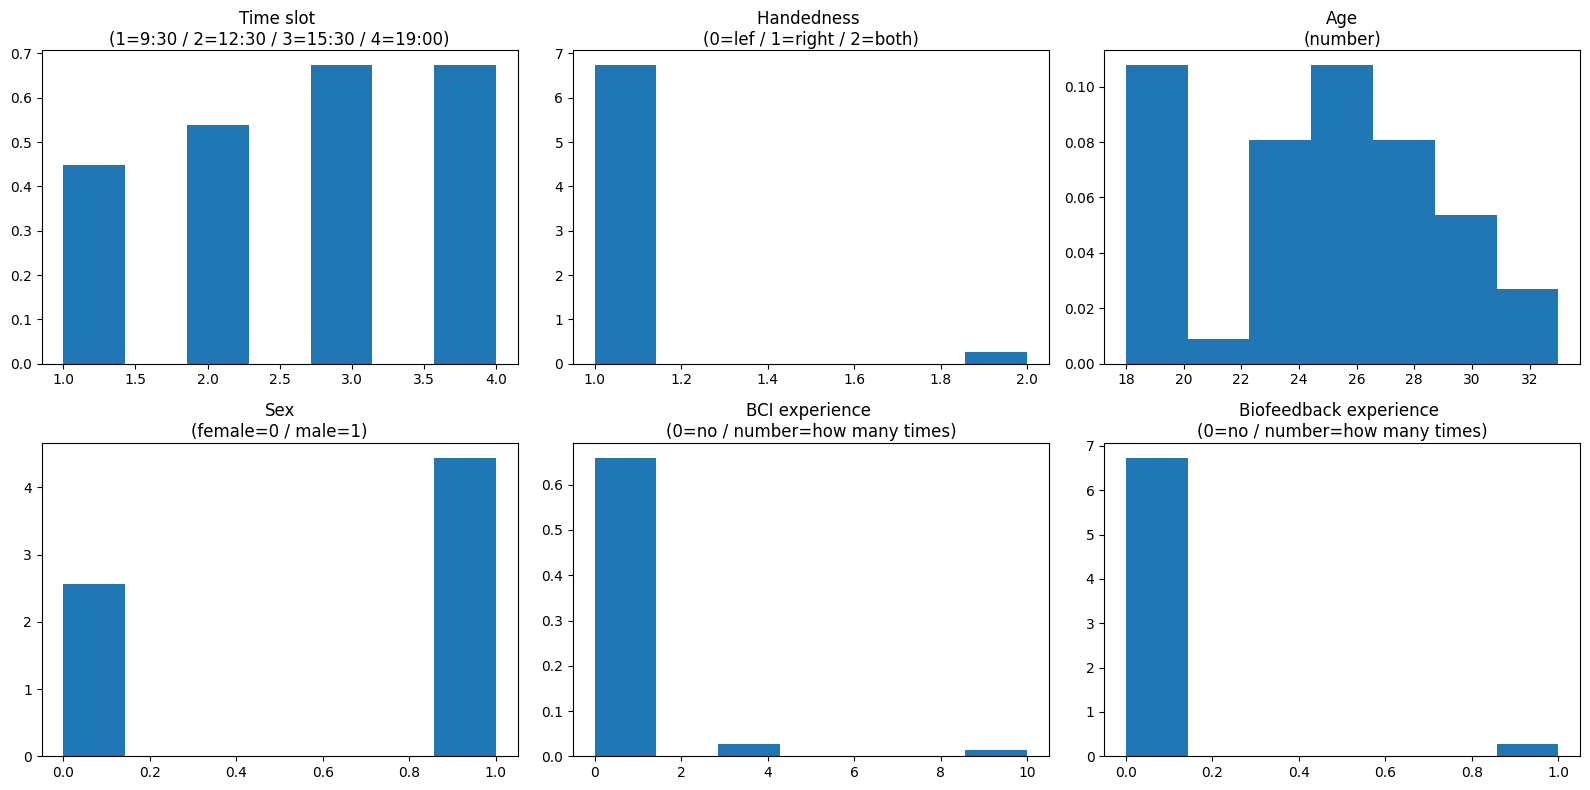

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8))
rows = len(pre_eeg)
for i in range(rows):
    row = int(i/3)
    column = i%3
    title = pre_eeg.iloc[i]['Questionaire']
    title2 = pre_eeg.iloc[i]['Unnamed: 3']
    if not pandas.isna(title2):
        title += f' ({title2})'
    ax[row][column].set_title(title.replace('(', '\n('), wrap=True)
    hist_data = ax[row][column].hist(pre_eeg.iloc[i]['s1':], density=True, bins='auto')
    entropy_ = entropy(hist_data[0])
    entropies += [entropy_]
    if entropy_>=threshold:
        clustering_data += [pre_eeg.iloc[i]['s1':].values]
        clustering_names += [f'{title}']
fig.tight_layout()
plt.show()

# Pre-MI

In [11]:
pre_mi

,Unnamed: 0,Questionaire,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,s1,s2,s3,...,s43,s44,s45,s46,s47,s48,s49,s50,s51,s52
9,107,3. How long did you sleep? (1=less than 4h / 2...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,...,3.0,4.0,4.00,3.0,3.0,3.0,4.0,3.0,3.0,4.0
10,107,4. Did you drink coffee within the past 24 hou...,NaN,NaN,NaN,NaN,NaN,12.0,2.0,20.0,...,0.0,22.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11,107,5. Did you drink alcohole within the past 24 h...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,15.0,...,0.0,0.0,0.00,22.0,8.0,0.0,0.0,0.0,0.0,0.0
12,107,6. Did you smoke within the past 24 hours (0=n...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,107,7. How do you feel?,NaN,NaN,Relaxed,1 2 3 4 5 Anxious,NaN,3.0,3.0,1.0,...,3.0,4.0,2.00,2.0,1.0,2.0,2.0,2.0,2.0,1.0
14,107,NaN,NaN,NaN,Exciting,1 2 3 4 5 Boring,NaN,1.0,3.0,1.0,...,3.0,4.0,4.00,5.0,2.0,4.0,2.0,3.0,2.0,2.0
15,107,NaN,NaN,Physical state,Very good,1 2 3 4 5 Very bad or tired,NaN,2.0,3.0,3.0,...,4.0,3.0,3.00,3.0,2.0,3.0,1.0,3.0,2.0,1.0
16,107,NaN,NaN,Mental state,Very good,1 2 3 4 5 Very bad or tired,NaN,2.0,4.0,2.0,...,3.0,3.0,3.00,4.0,2.0,3.0,1.0,3.0,2.0,1.0
17,107,8. The BCI perfromance (accuracy) expected? (%),NaN,NaN,NaN,NaN,NaN,80.0,60.0,70.0,...,50.0,60.0,83.33,65.0,80.0,70.0,80.0,70.0,80.0,90.0


/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:400: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:401: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


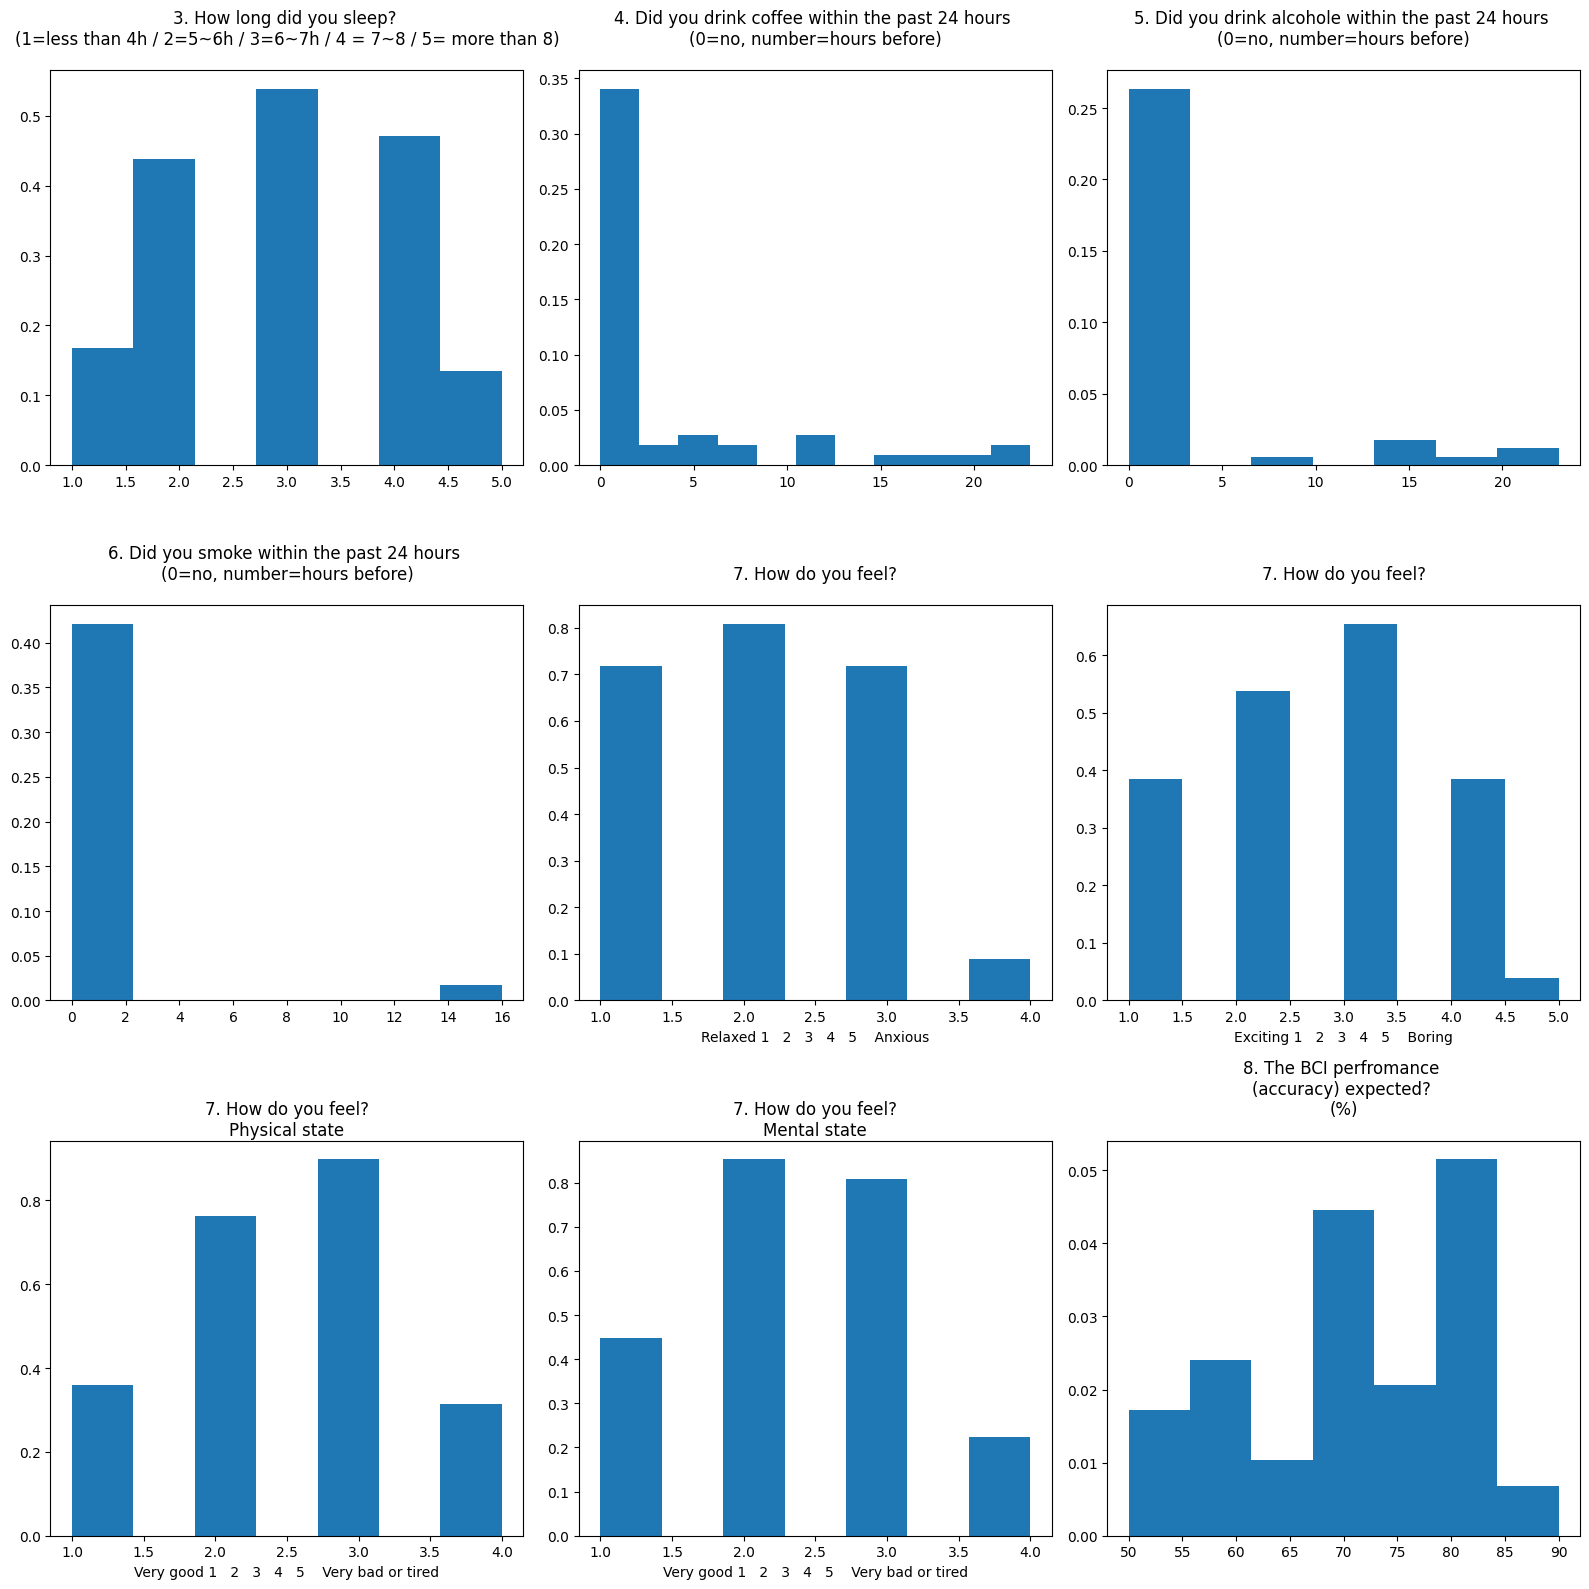

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(16, 16))
rows = len(pre_mi)
for i in range(rows):
    row = int(i/3)
    column = i%3
    if not pandas.isna(pre_mi.iloc[i]['Questionaire']):
        title = pre_mi.iloc[i]['Questionaire']
    title2 = pre_mi.iloc[i]['Unnamed: 3']
    x_label = pre_mi.iloc[i]['Unnamed: 4']
    if pandas.isna(x_label):
        x_label=''
    if not pandas.isna(pre_mi.iloc[i]["Unnamed: 5"]):
        x_label += f' {pre_mi.iloc[i]["Unnamed: 5"]}'
    else:
        x_label = ''
    if pandas.isna(title2):
        title2 = ''
    ax[row][column].set_title(f'{title}\n{title2}'.replace('(', '\n('), wrap=True)
    ax[row][column].set_xlabel(x_label)
    hist_data = ax[row][column].hist(pre_mi.iloc[i]['s1':], density=True, bins='auto')
    entropy_ = entropy(hist_data[0])
    entropies += [entropy_]
    if entropy_>=threshold:
        clustering_data += [pre_mi.iloc[i]['s1':].values]
        clustering_names += [f'{title} | {x_label}']
fig.tight_layout()
plt.show()

# Post Run 1

In [ ]:
post_run1

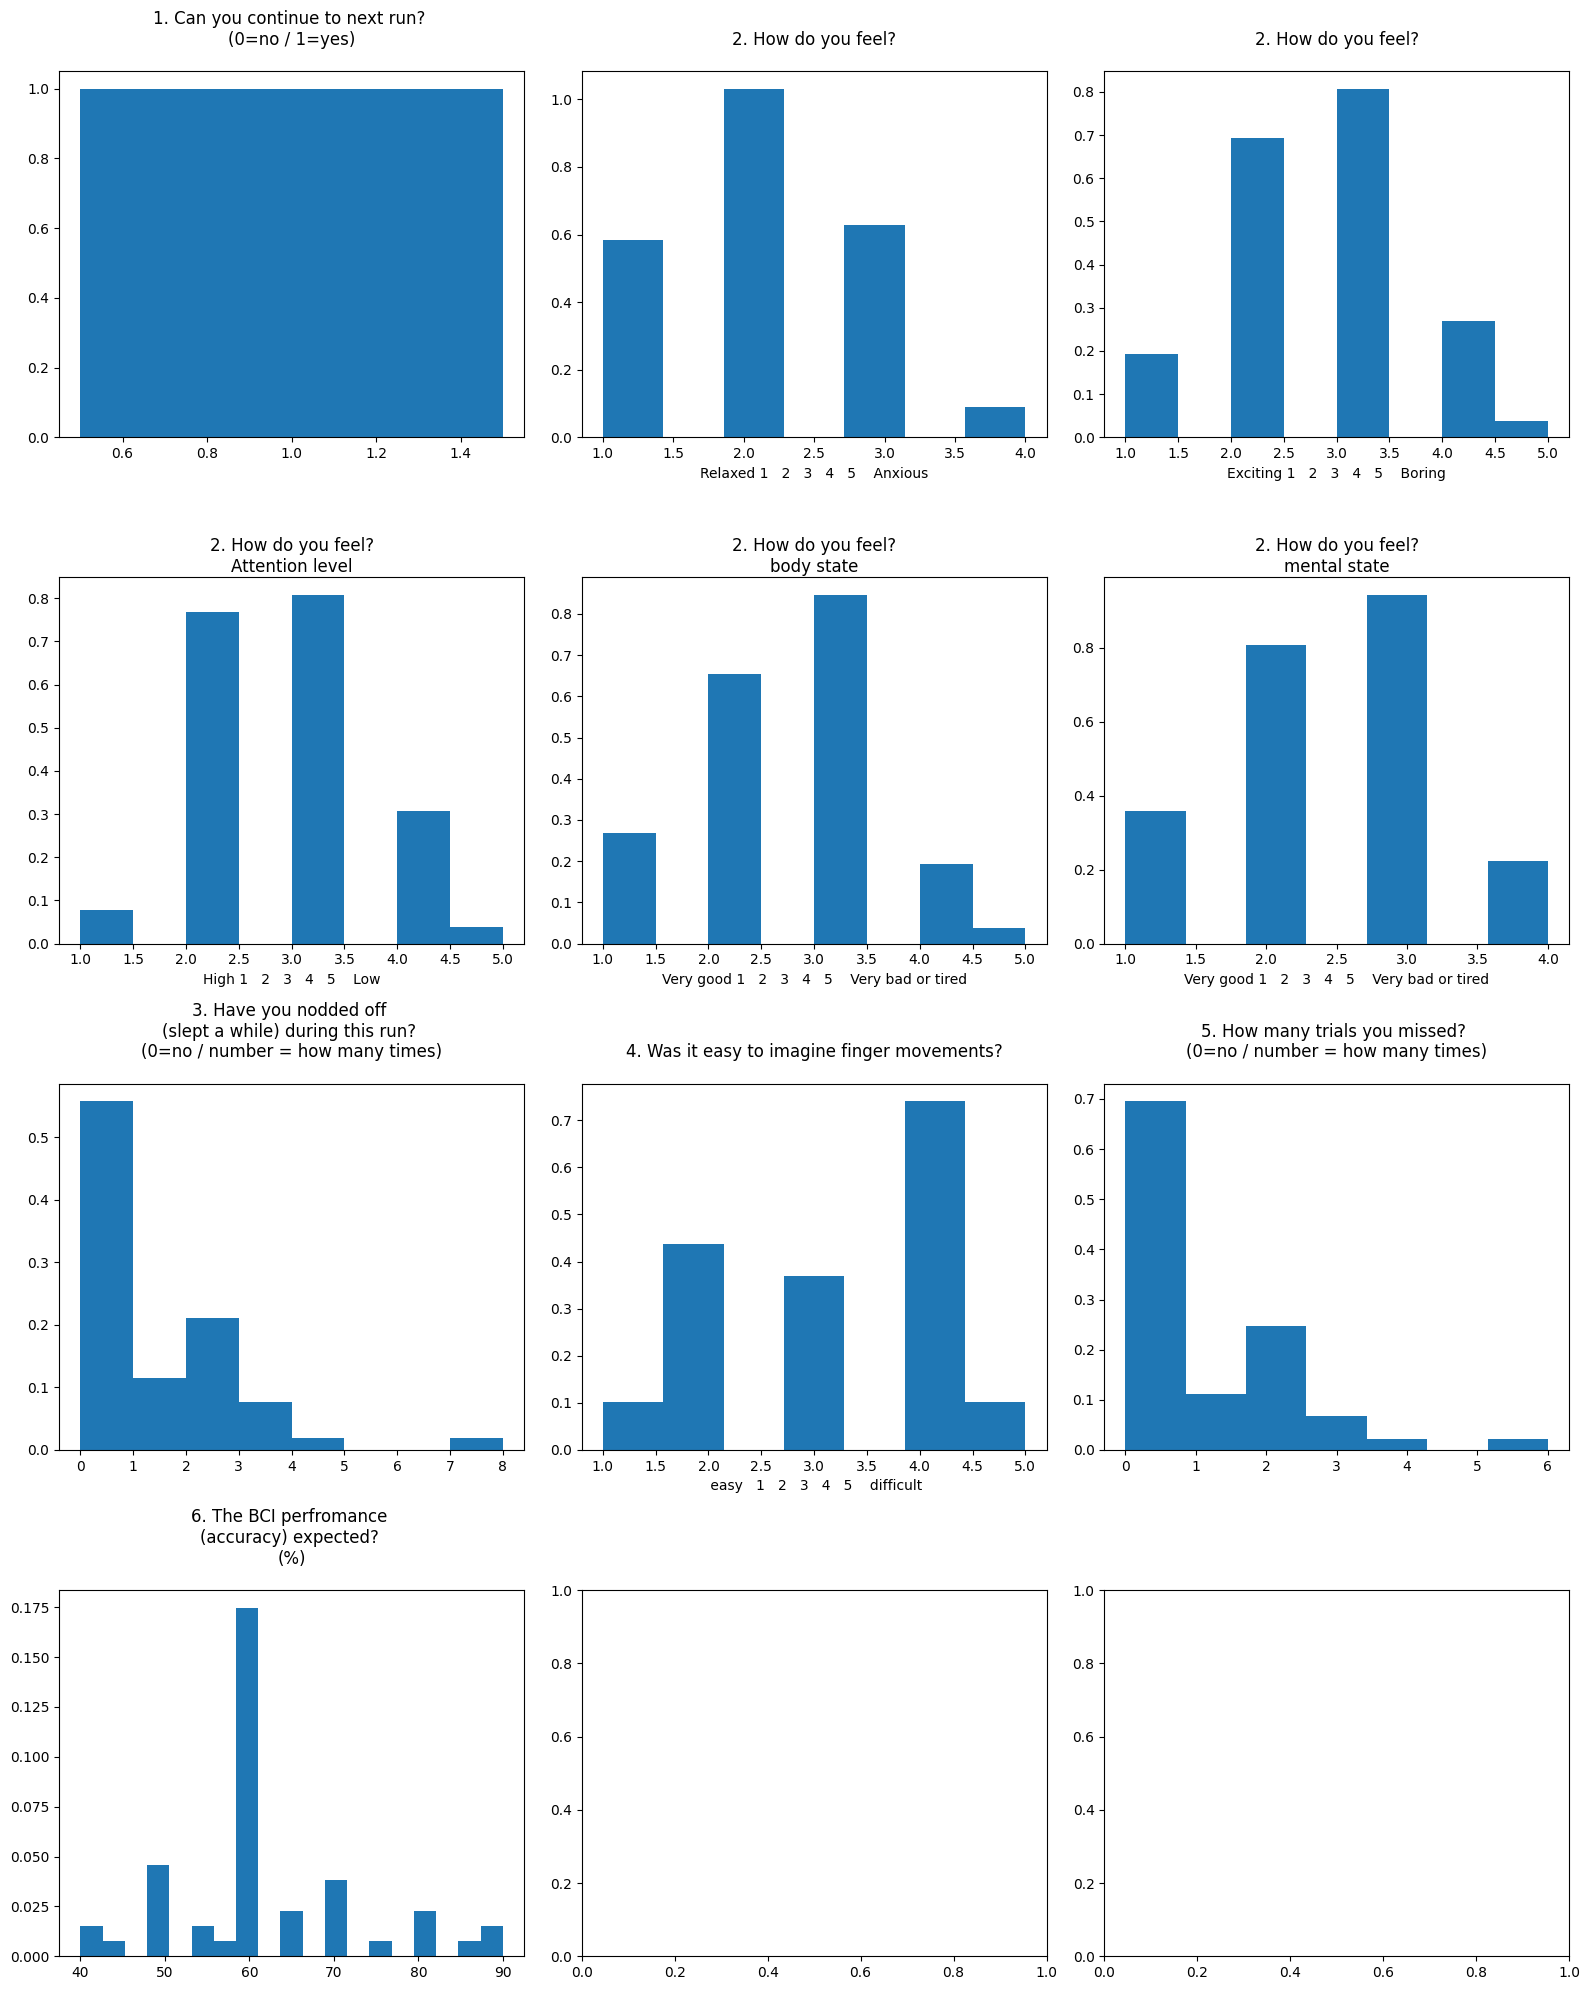

In [14]:
fig, ax = plt.subplots(4, 3, figsize=(16, 20))
df = post_run1
rows = len(df)
for i in range(rows):
    row = int(i/3)
    column = i%3
    if not pandas.isna(df.iloc[i]['Questionaire']):
        title = df.iloc[i]['Questionaire']
    title2 = df.iloc[i]['Unnamed: 3']
    x_label = df.iloc[i]['Unnamed: 4']
    if pandas.isna(x_label):
        x_label=''
    if not pandas.isna(df.iloc[i]["Unnamed: 5"]):
        x_label += f' {df.iloc[i]["Unnamed: 5"]}'
    else:
        x_label = ''
    if pandas.isna(title2):
        title2 = ''
    ax[row][column].set_title(f'{title}\n{title2}'.replace('(', '\n('), wrap=True)
    ax[row][column].set_xlabel(x_label)
    hist_data = ax[row][column].hist(df.iloc[i]['s1':], density=True, bins='auto')
    entropy_ = entropy(hist_data[0])
    entropies += [entropy_]
    if entropy_>=threshold:
        clustering_data += [df.iloc[i]['s1':].values]
        clustering_names += [f'{title} | {x_label}']
fig.tight_layout()
plt.show()

# Post Run 2

In [15]:
post_run2

,Unnamed: 0,Questionaire,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,s1,s2,s3,...,s43,s44,s45,s46,s47,s48,s49,s50,s51,s52
31,220,1. Can you continue to next run? (0=no / 1=yes),NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
32,221,2. How do you feel?,NaN,NaN,relaxed,1 2 3 4 5 anxious,NaN,3.0,3.0,2.0,...,2.0,3.0,2.0,3.0,1.0,2.0,2.0,1.0,2.0,1.0
33,222,NaN,NaN,NaN,exciting,1 2 3 4 5 boring,NaN,2.0,3.0,2.0,...,2.0,4.0,3.0,3.0,3.0,4.0,1.0,2.0,2.0,2.0
34,223,NaN,NaN,attention level,high,1 2 3 4 5 low,NaN,3.0,4.0,2.0,...,2.0,4.0,2.0,2.0,3.0,4.0,2.0,2.0,3.0,1.0
35,224,NaN,NaN,body state,very good,1 2 3 4 5 very bad or tired,NaN,3.0,3.0,2.0,...,3.0,3.0,2.0,3.0,3.0,3.0,1.0,2.0,2.0,1.0
36,225,NaN,NaN,mental state,very good,1 2 3 4 5 very bad or tired,NaN,2.0,4.0,2.0,...,3.0,3.0,3.0,2.0,3.0,3.0,1.0,3.0,2.0,1.0
37,226,3. Have you nodded off (slept in a while) duri...,NaN,NaN,NaN,NaN,NaN,0.0,1.5,0.0,...,0.0,2.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
38,227,4. Was it easy to imagine finger movements?,NaN,NaN,NaN,easy 1 2 3 4 5 difficult,NaN,3.0,4.0,2.0,...,2.0,3.0,1.0,3.0,2.0,4.0,2.0,2.0,3.0,1.0
39,228,5. How many trials you missed? (0=no / number ...,NaN,NaN,NaN,NaN,NaN,1.5,1.5,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,229,6. The BCI perfromance (accuracy) expected? (%),NaN,NaN,NaN,NaN,NaN,70.0,50.0,80.0,...,70.0,60.0,70.0,70.0,60.0,60.0,65.0,70.0,60.0,90.0


/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:400: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:401: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


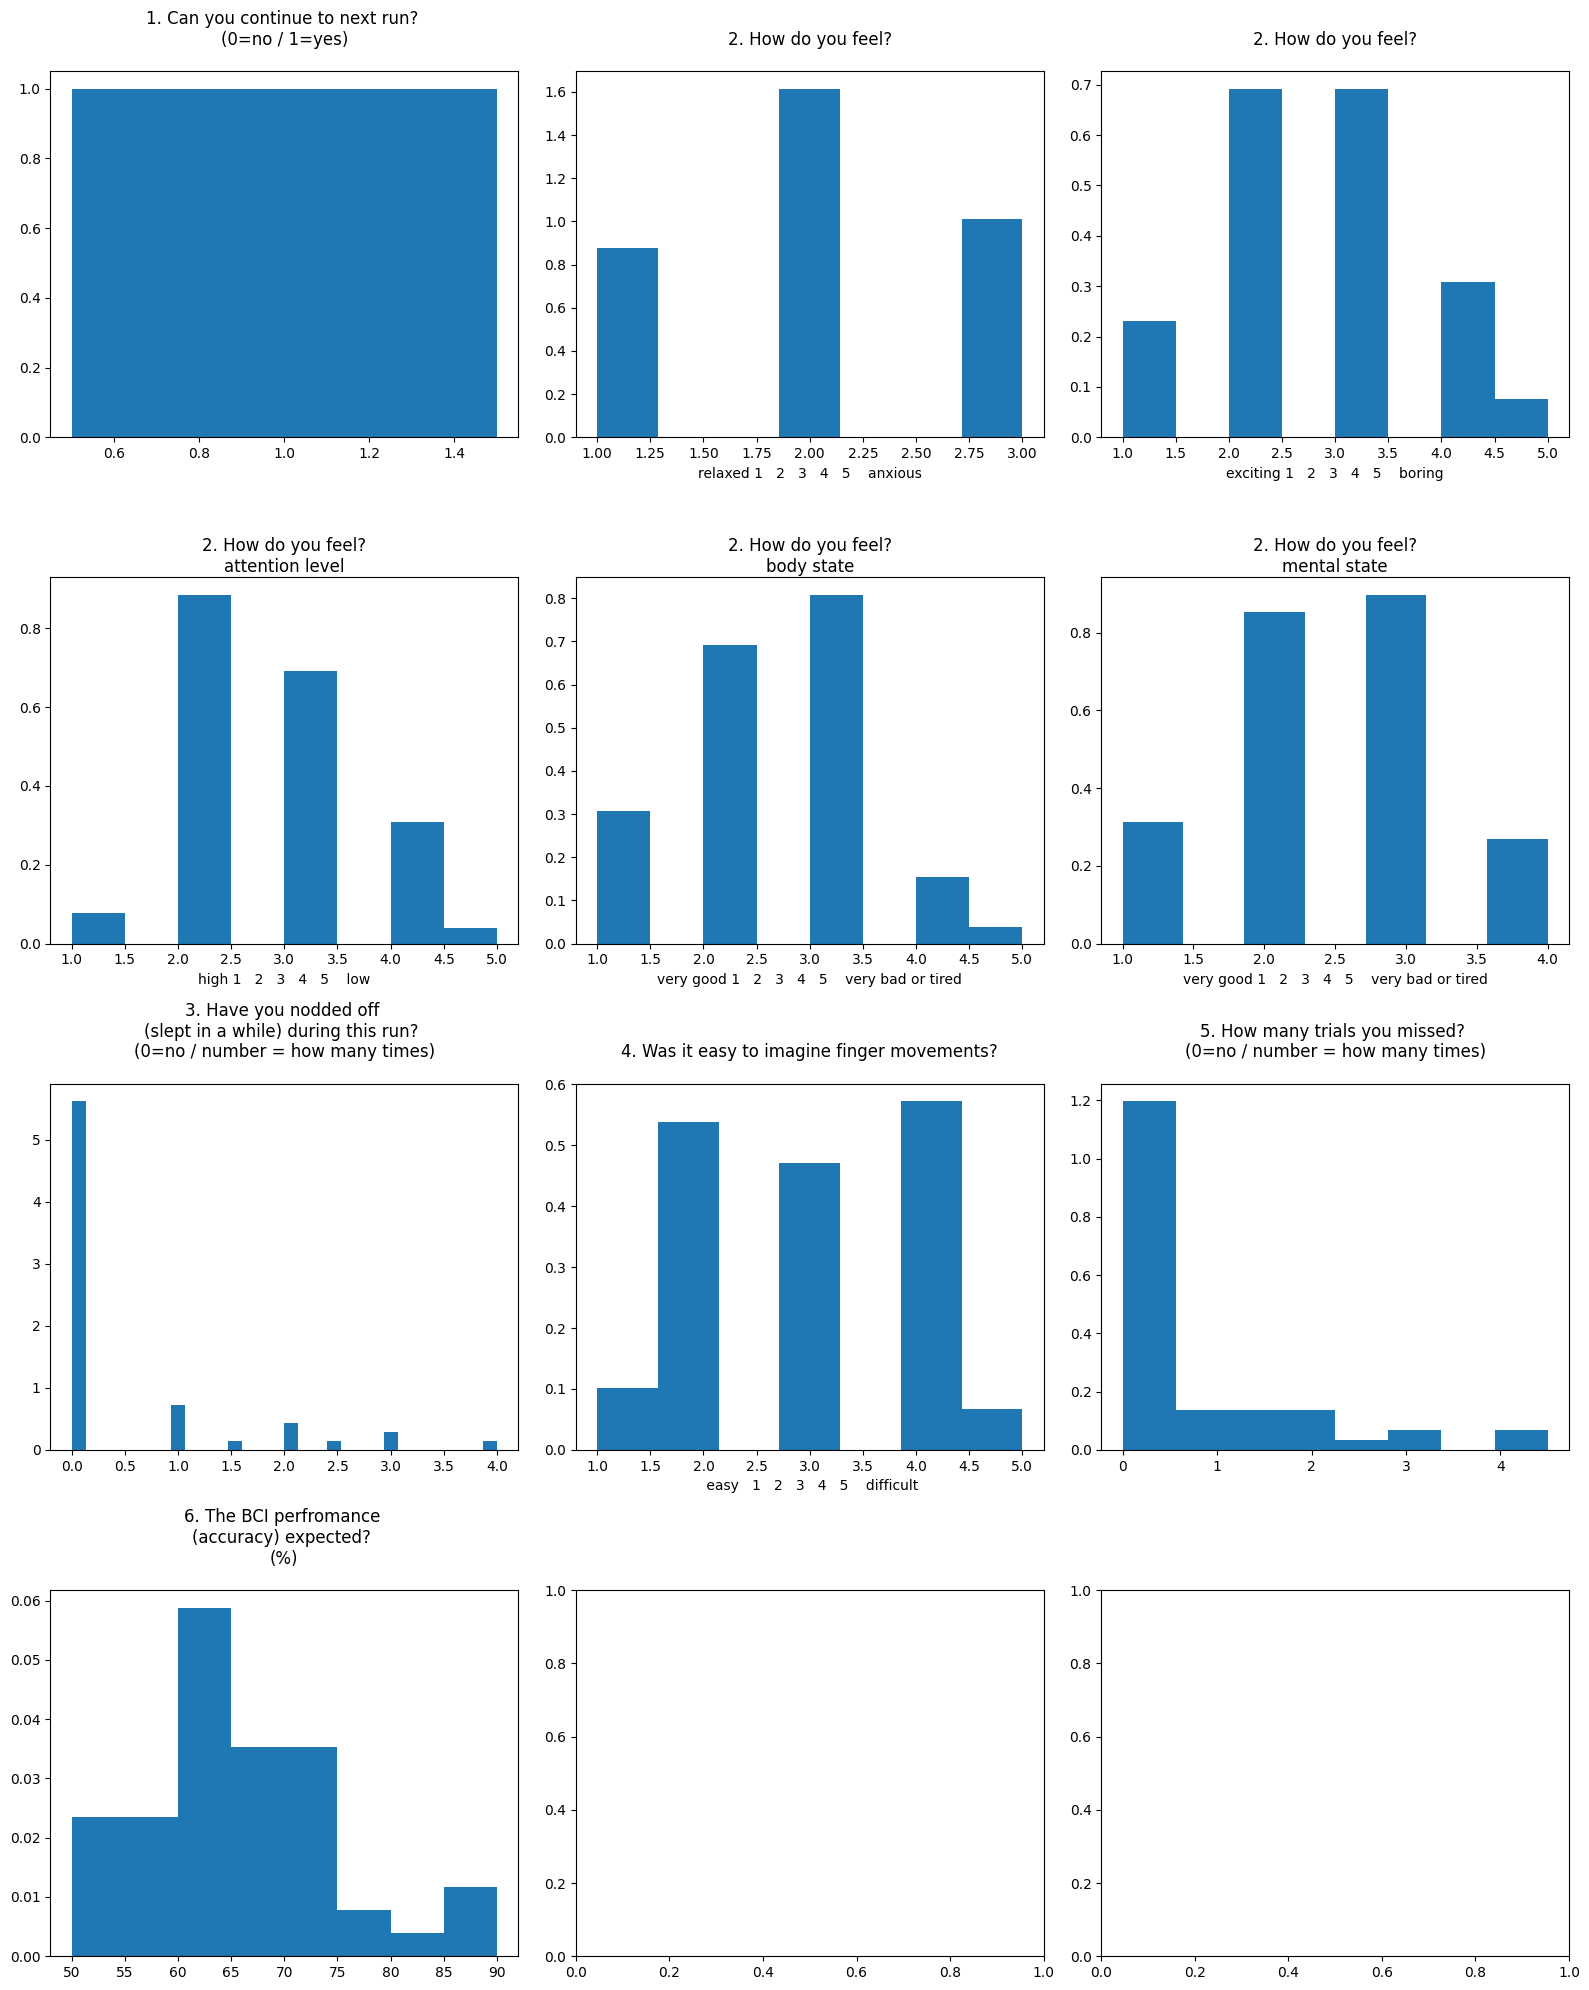

In [16]:
fig, ax = plt.subplots(4, 3, figsize=(16, 20))
df = post_run2
rows = len(df)
for i in range(rows):
    row = int(i/3)
    column = i%3
    if not pandas.isna(df.iloc[i]['Questionaire']):
        title = df.iloc[i]['Questionaire']
    title2 = df.iloc[i]['Unnamed: 3']
    x_label = df.iloc[i]['Unnamed: 4']
    if pandas.isna(x_label):
        x_label=''
    if not pandas.isna(df.iloc[i]["Unnamed: 5"]):
        x_label += f' {df.iloc[i]["Unnamed: 5"]}'
    else:
        x_label = ''
    if pandas.isna(title2):
        title2 = ''
    ax[row][column].set_title(f'{title}\n{title2}'.replace('(', '\n('), wrap=True)
    ax[row][column].set_xlabel(x_label)
    hist_data = ax[row][column].hist(df.iloc[i]['s1':], density=True, bins='auto')
    entropy_ = entropy(hist_data[0])
    entropies += [entropy_]
    if entropy_>=threshold:
        clustering_data += [df.iloc[i]['s1':].values]
        clustering_names += [f'{title} | {x_label}']
fig.tight_layout()
plt.show()

# Post Run 3

In [17]:
post_run3

,Unnamed: 0,Questionaire,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,s1,s2,s3,...,s43,s44,s45,s46,s47,s48,s49,s50,s51,s52
42,230,1. Can you continue to next run? (0=no / 1=yes),NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
43,231,2. How do you feel?,NaN,NaN,relaxed,1 2 3 4 5 anxious,NaN,3.0,3.0,2.0,...,2.0,4.0,3.0,3.0,3.0,2.0,1.0,2.0,2.0,1.0
44,232,NaN,NaN,NaN,exciting,1 2 3 4 5 boring,NaN,2.0,3.0,3.0,...,2.0,3.0,4.0,3.0,3.0,4.0,1.0,2.0,2.0,2.0
45,233,NaN,NaN,attention level,high,1 2 3 4 5 low,NaN,3.0,3.0,3.0,...,2.0,4.0,4.0,3.0,3.0,4.0,1.0,2.0,3.0,1.0
46,234,NaN,NaN,body state,very good,1 2 3 4 5 very bad or tired,NaN,3.0,3.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,2.0,1.0
47,235,NaN,NaN,mental state,very good,1 2 3 4 5 very bad or tired,NaN,2.0,3.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,3.0,1.0
48,236,3. Have you nodded off (slept in a while) duri...,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,...,0.0,0.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
49,237,4. Was it easy to imagine finger movements?,NaN,NaN,NaN,easy 1 2 3 4 5 difficult,NaN,2.0,3.0,2.0,...,1.0,3.0,1.0,3.0,3.0,4.0,2.0,2.0,3.0,1.0
50,238,5. How many trials you missed? (0=no / number ...,NaN,NaN,NaN,NaN,NaN,2.5,0.0,3.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
51,239,6. The BCI perfromance (accuracy) expected? (%),NaN,NaN,NaN,NaN,NaN,70.0,60.0,70.0,...,80.0,60.0,58.0,70.0,50.0,60.0,75.0,80.0,60.0,90.0


/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:400: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:401: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


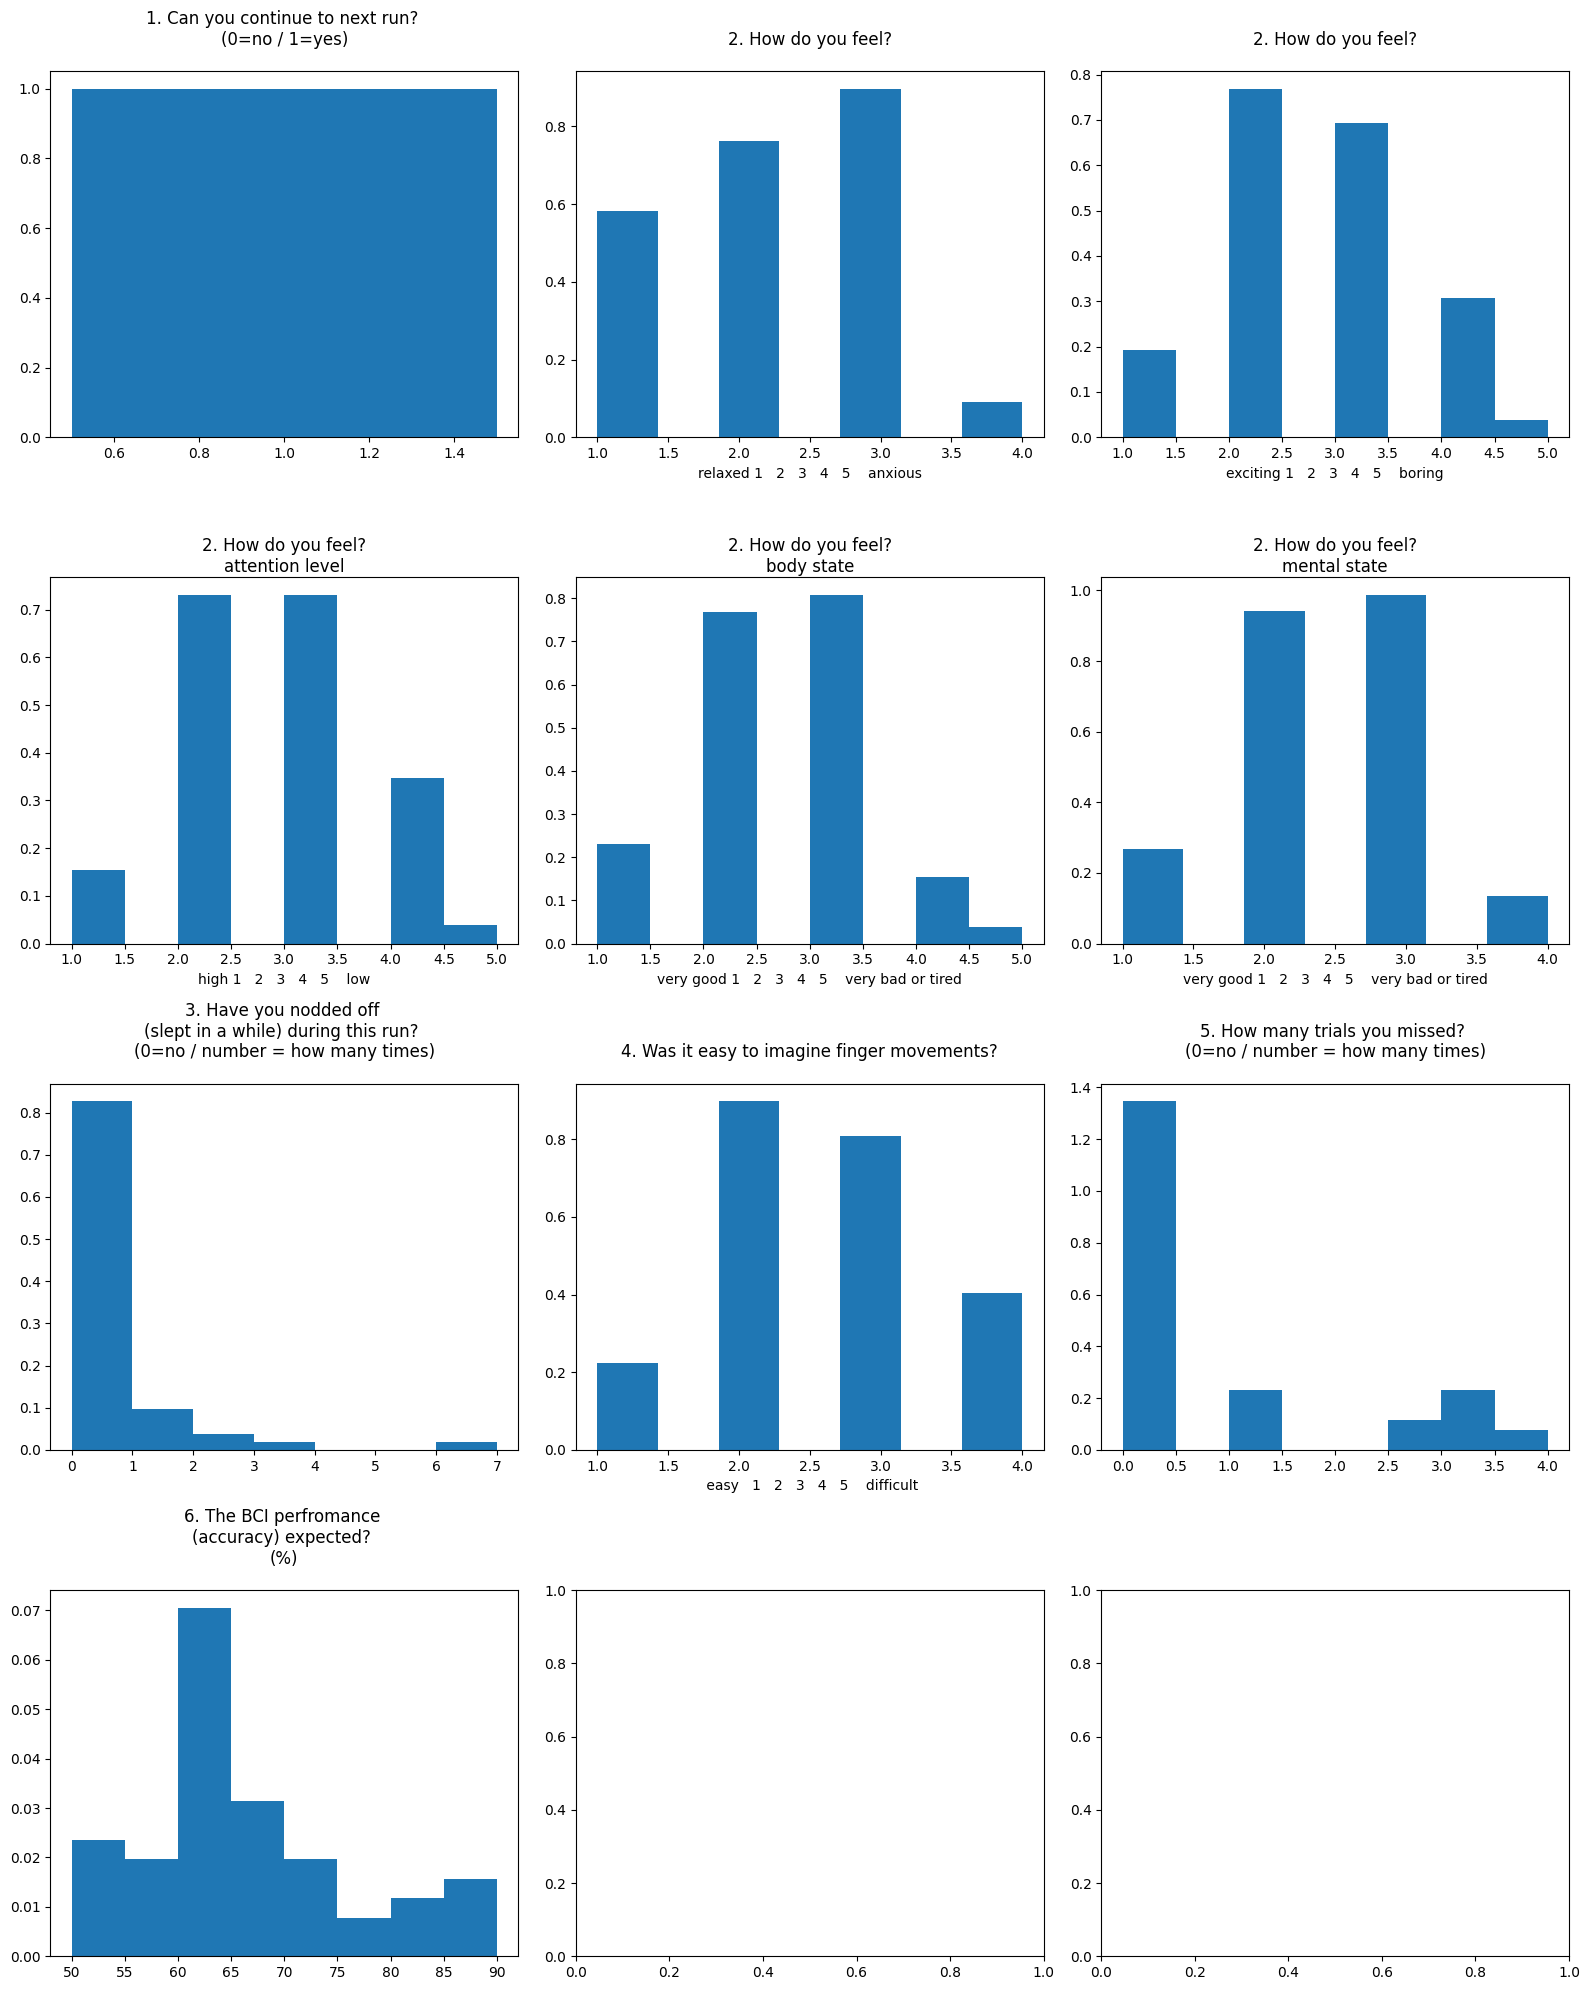

In [18]:
fig, ax = plt.subplots(4, 3, figsize=(16, 20))
df = post_run3
rows = len(df)
for i in range(rows):
    row = int(i/3)
    column = i%3
    if not pandas.isna(df.iloc[i]['Questionaire']):
        title = df.iloc[i]['Questionaire']
    title2 = df.iloc[i]['Unnamed: 3']
    x_label = df.iloc[i]['Unnamed: 4']
    if pandas.isna(x_label):
        x_label=''
    if not pandas.isna(df.iloc[i]["Unnamed: 5"]):
        x_label += f' {df.iloc[i]["Unnamed: 5"]}'
    else:
        x_label = ''
    if pandas.isna(title2):
        title2 = ''
    ax[row][column].set_title(f'{title}\n{title2}'.replace('(', '\n('), wrap=True)
    ax[row][column].set_xlabel(x_label)
    hist_data = ax[row][column].hist(df.iloc[i]['s1':], density=True, bins='auto')
    entropy_ = entropy(hist_data[0])
    entropies += [entropy_]
    if entropy_>=threshold:
        clustering_data += [df.iloc[i]['s1':].values]
        clustering_names += [f'{title} | {x_label}']
fig.tight_layout()
plt.show()

# Post Run 4

In [19]:
post_run4

,Unnamed: 0,Questionaire,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,s1,s2,s3,...,s43,s44,s45,s46,s47,s48,s49,s50,s51,s52
53,240,1. Can you continue to next run? (0=no / 1=yes),NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
54,241,2. How do you feel?,NaN,NaN,relaxed,1 2 3 4 5 anxious,NaN,3.0,3.0,2.0,...,2.0,4.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,1.0
55,242,NaN,NaN,NaN,exciting,1 2 3 4 5 boring,NaN,2.0,3.0,2.0,...,2.0,4.0,4.0,4.0,3.0,4.0,1.0,3.0,2.0,2.0
56,243,NaN,NaN,attention level,high,1 2 3 4 5 low,NaN,2.0,3.0,2.0,...,2.0,3.0,4.0,2.0,3.0,4.0,2.0,3.0,4.0,1.0
57,244,NaN,NaN,body state,very good,1 2 3 4 5 very bad or tired,NaN,3.0,3.0,2.0,...,2.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,3.0,1.0
58,245,NaN,NaN,mental state,very good,1 2 3 4 5 very bad or tired,NaN,2.0,3.0,2.0,...,2.0,3.0,4.0,2.0,3.0,3.0,2.0,2.0,3.0,1.0
59,246,3. Have you nodded off (slept in a while) duri...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0
60,247,4. Was it easy to imagine finger movements?,NaN,NaN,NaN,easy 1 2 3 4 5 difficult,NaN,2.0,3.0,2.0,...,1.0,3.0,2.0,3.0,3.0,3.0,1.0,3.0,3.0,1.0
61,248,5. How many trials you missed? (0=no / number ...,NaN,NaN,NaN,NaN,NaN,2.5,0.0,3.0,...,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
62,249,6. The BCI perfromance (accuracy) expected? (%),NaN,NaN,NaN,NaN,NaN,70.0,60.0,70.0,...,80.0,60.0,60.0,70.0,60.0,70.0,85.0,75.0,60.0,80.0


/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:400: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:401: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


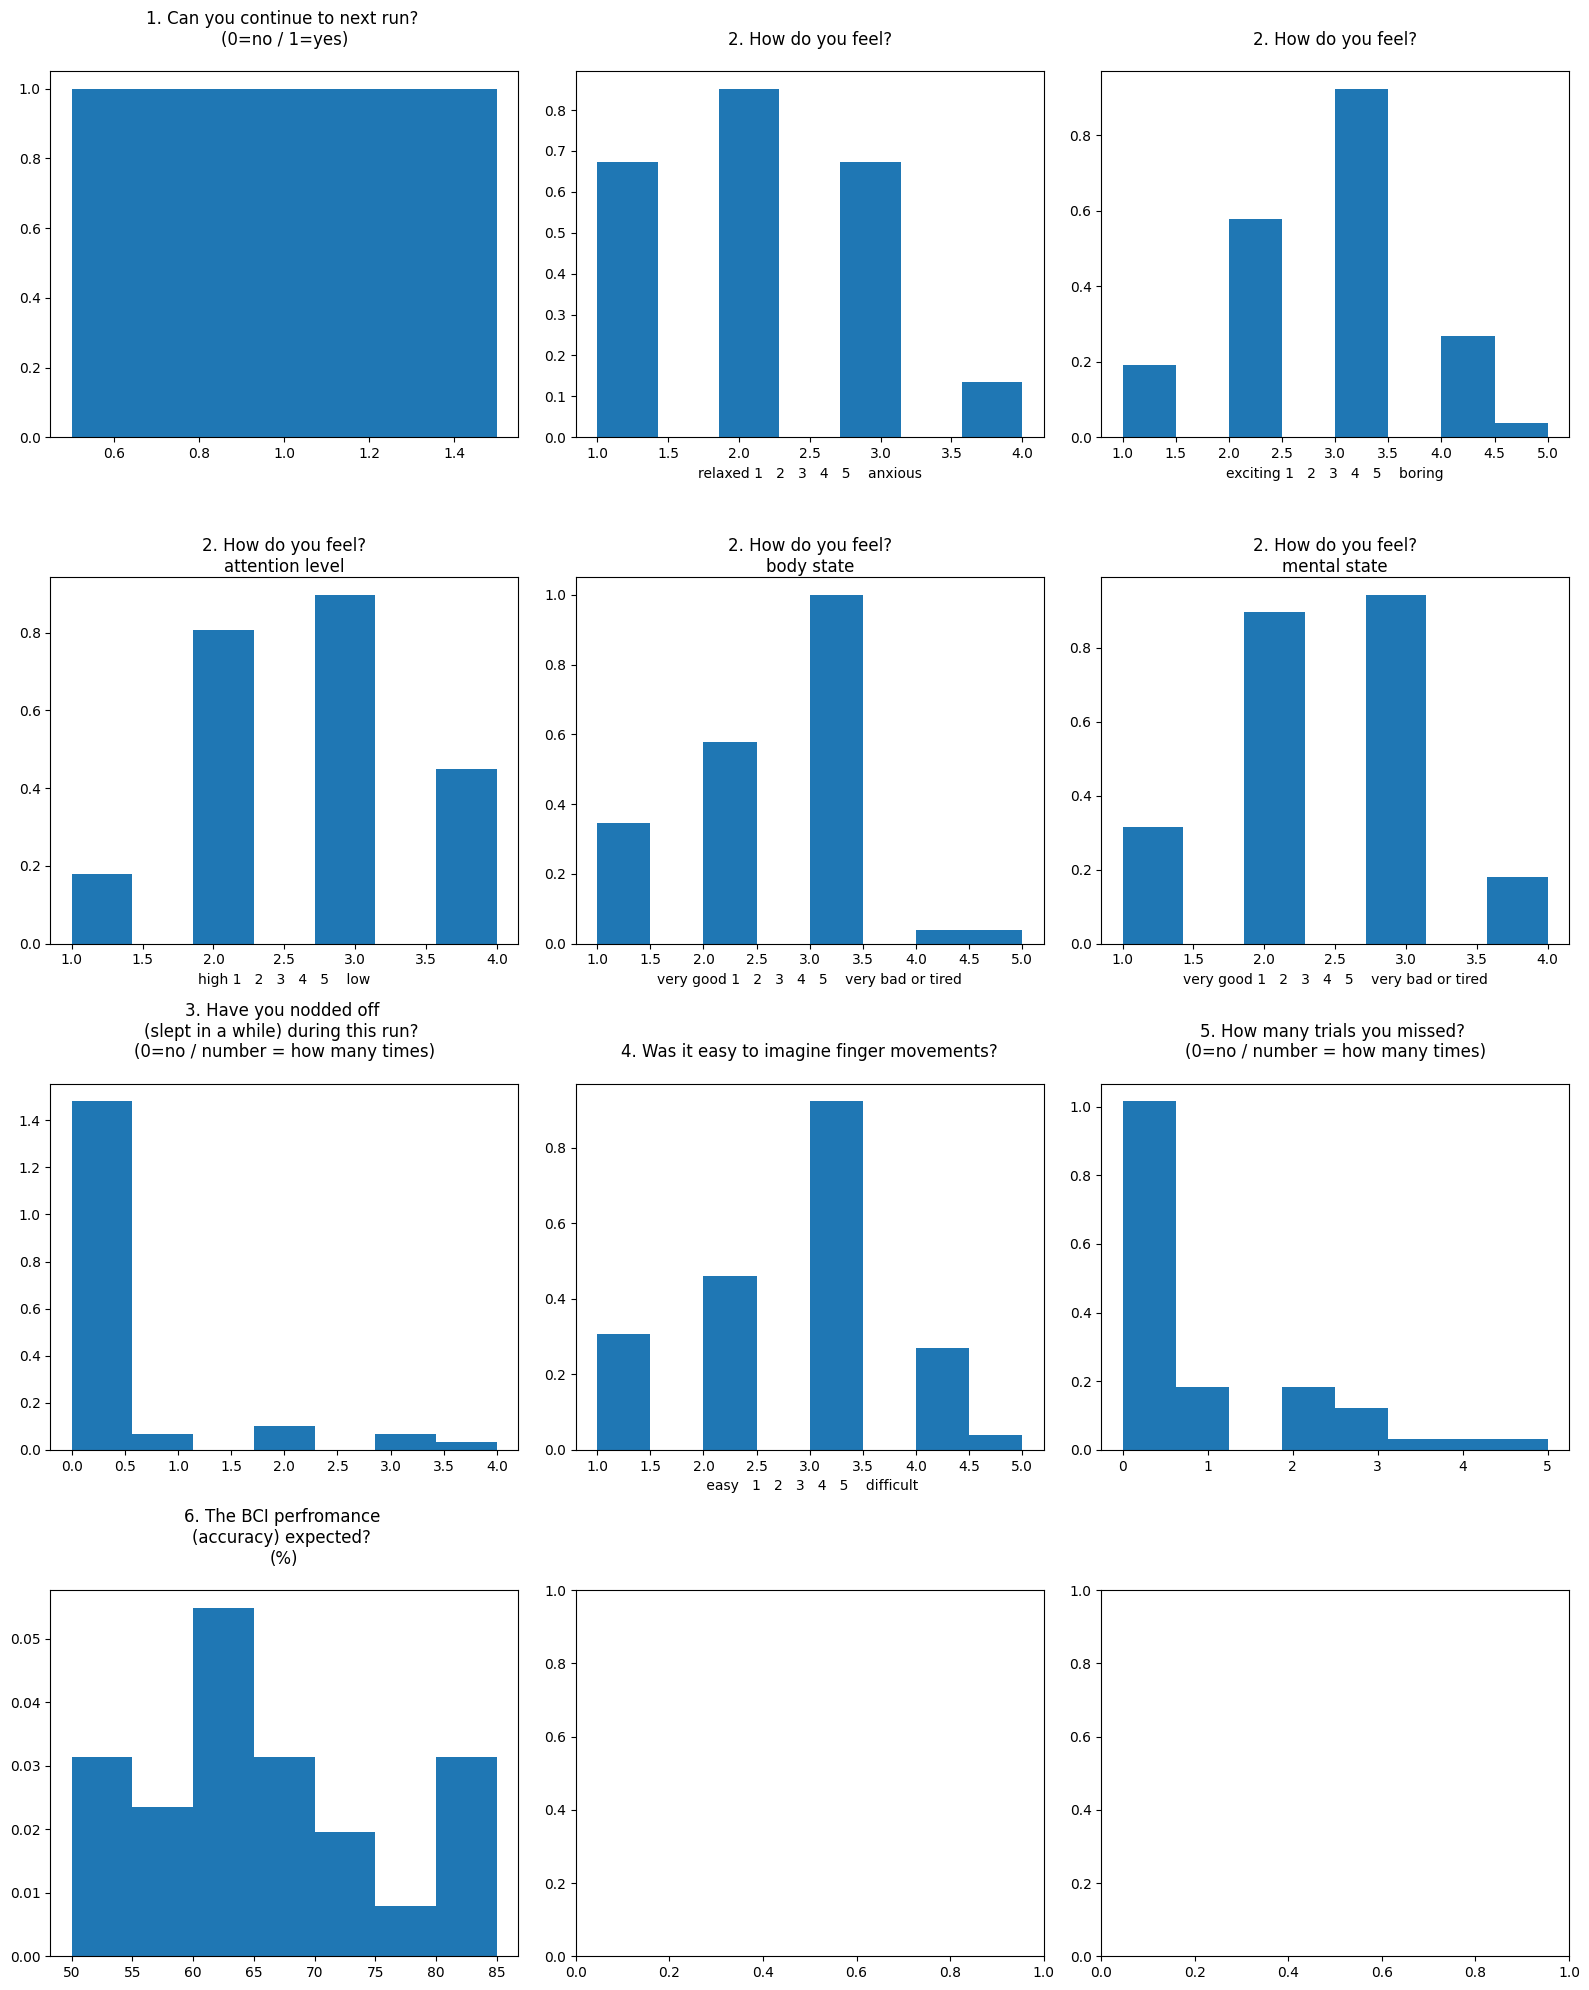

In [20]:
fig, ax = plt.subplots(4, 3, figsize=(16, 20))
df = post_run4
rows = len(df)
for i in range(rows):
    row = int(i/3)
    column = i%3
    if not pandas.isna(df.iloc[i]['Questionaire']):
        title = df.iloc[i]['Questionaire']
    title2 = df.iloc[i]['Unnamed: 3']
    x_label = df.iloc[i]['Unnamed: 4']
    if pandas.isna(x_label):
        x_label=''
    if not pandas.isna(df.iloc[i]["Unnamed: 5"]):
        x_label += f' {df.iloc[i]["Unnamed: 5"]}'
    else:
        x_label = ''
    if pandas.isna(title2):
        title2 = ''
    ax[row][column].set_title(f'{title}\n{title2}'.replace('(', '\n('), wrap=True)
    ax[row][column].set_xlabel(x_label)
    hist_data = ax[row][column].hist(df.iloc[i]['s1':], density=True, bins='auto')
    entropy_ = entropy(hist_data[0])
    entropies += [entropy_]
    if entropy_>=threshold:
        clustering_data += [df.iloc[i]['s1':].values]
        clustering_names += [f'{title} | {x_label}']
fig.tight_layout()
plt.show()

# Post Run 5

In [21]:
post_run5

,Unnamed: 0,Questionaire,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,s1,s2,s3,...,s43,s44,s45,s46,s47,s48,s49,s50,s51,s52
64,250,1. Can you continue to next run? (0=no / 1=yes),NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
65,251,2. How do you feel?,NaN,NaN,relaxed,1 2 3 4 5 anxious,NaN,3.0,3.0,2.0,...,2.0,3.0,3.0,4.0,3.0,2.0,1.0,2.0,2.0,1.0
66,252,NaN,NaN,NaN,exciting,1 2 3 4 5 boring,NaN,2.0,3.0,3.0,...,2.0,4.0,4.0,3.0,3.0,4.0,2.0,3.0,2.0,2.0
67,253,NaN,NaN,attention level,high,1 2 3 4 5 low,NaN,2.0,3.0,3.0,...,2.0,3.0,4.0,3.0,3.0,4.0,2.0,3.0,2.0,1.0
68,254,NaN,NaN,body state,very good,1 2 3 4 5 very bad or tired,NaN,2.0,3.0,2.0,...,2.0,3.0,3.0,3.0,3.0,3.0,1.0,3.0,2.0,1.0
69,255,NaN,NaN,mental state,very good,1 2 3 4 5 very bad or tired,NaN,2.0,3.0,2.0,...,2.0,4.0,4.0,3.0,3.0,3.0,1.0,3.0,2.0,1.0
70,256,3. Have you nodded off (slept in a while) duri...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
71,257,4. Was it easy to imagine finger movements?,NaN,NaN,NaN,easy 1 2 3 4 5 difficult,NaN,2.0,2.0,2.0,...,1.0,3.0,1.0,3.0,2.0,3.0,2.0,3.0,4.0,1.0
72,258,5. How many trials you missed? (0=no / number ...,NaN,NaN,NaN,NaN,NaN,2.5,0.0,2.0,...,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0
73,259,6. The BCI perfromance (accuracy) expected? (%),NaN,NaN,NaN,NaN,NaN,70.0,60.0,75.0,...,80.0,70.0,62.0,70.0,60.0,70.0,90.0,70.0,55.0,80.0


/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:400: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:401: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


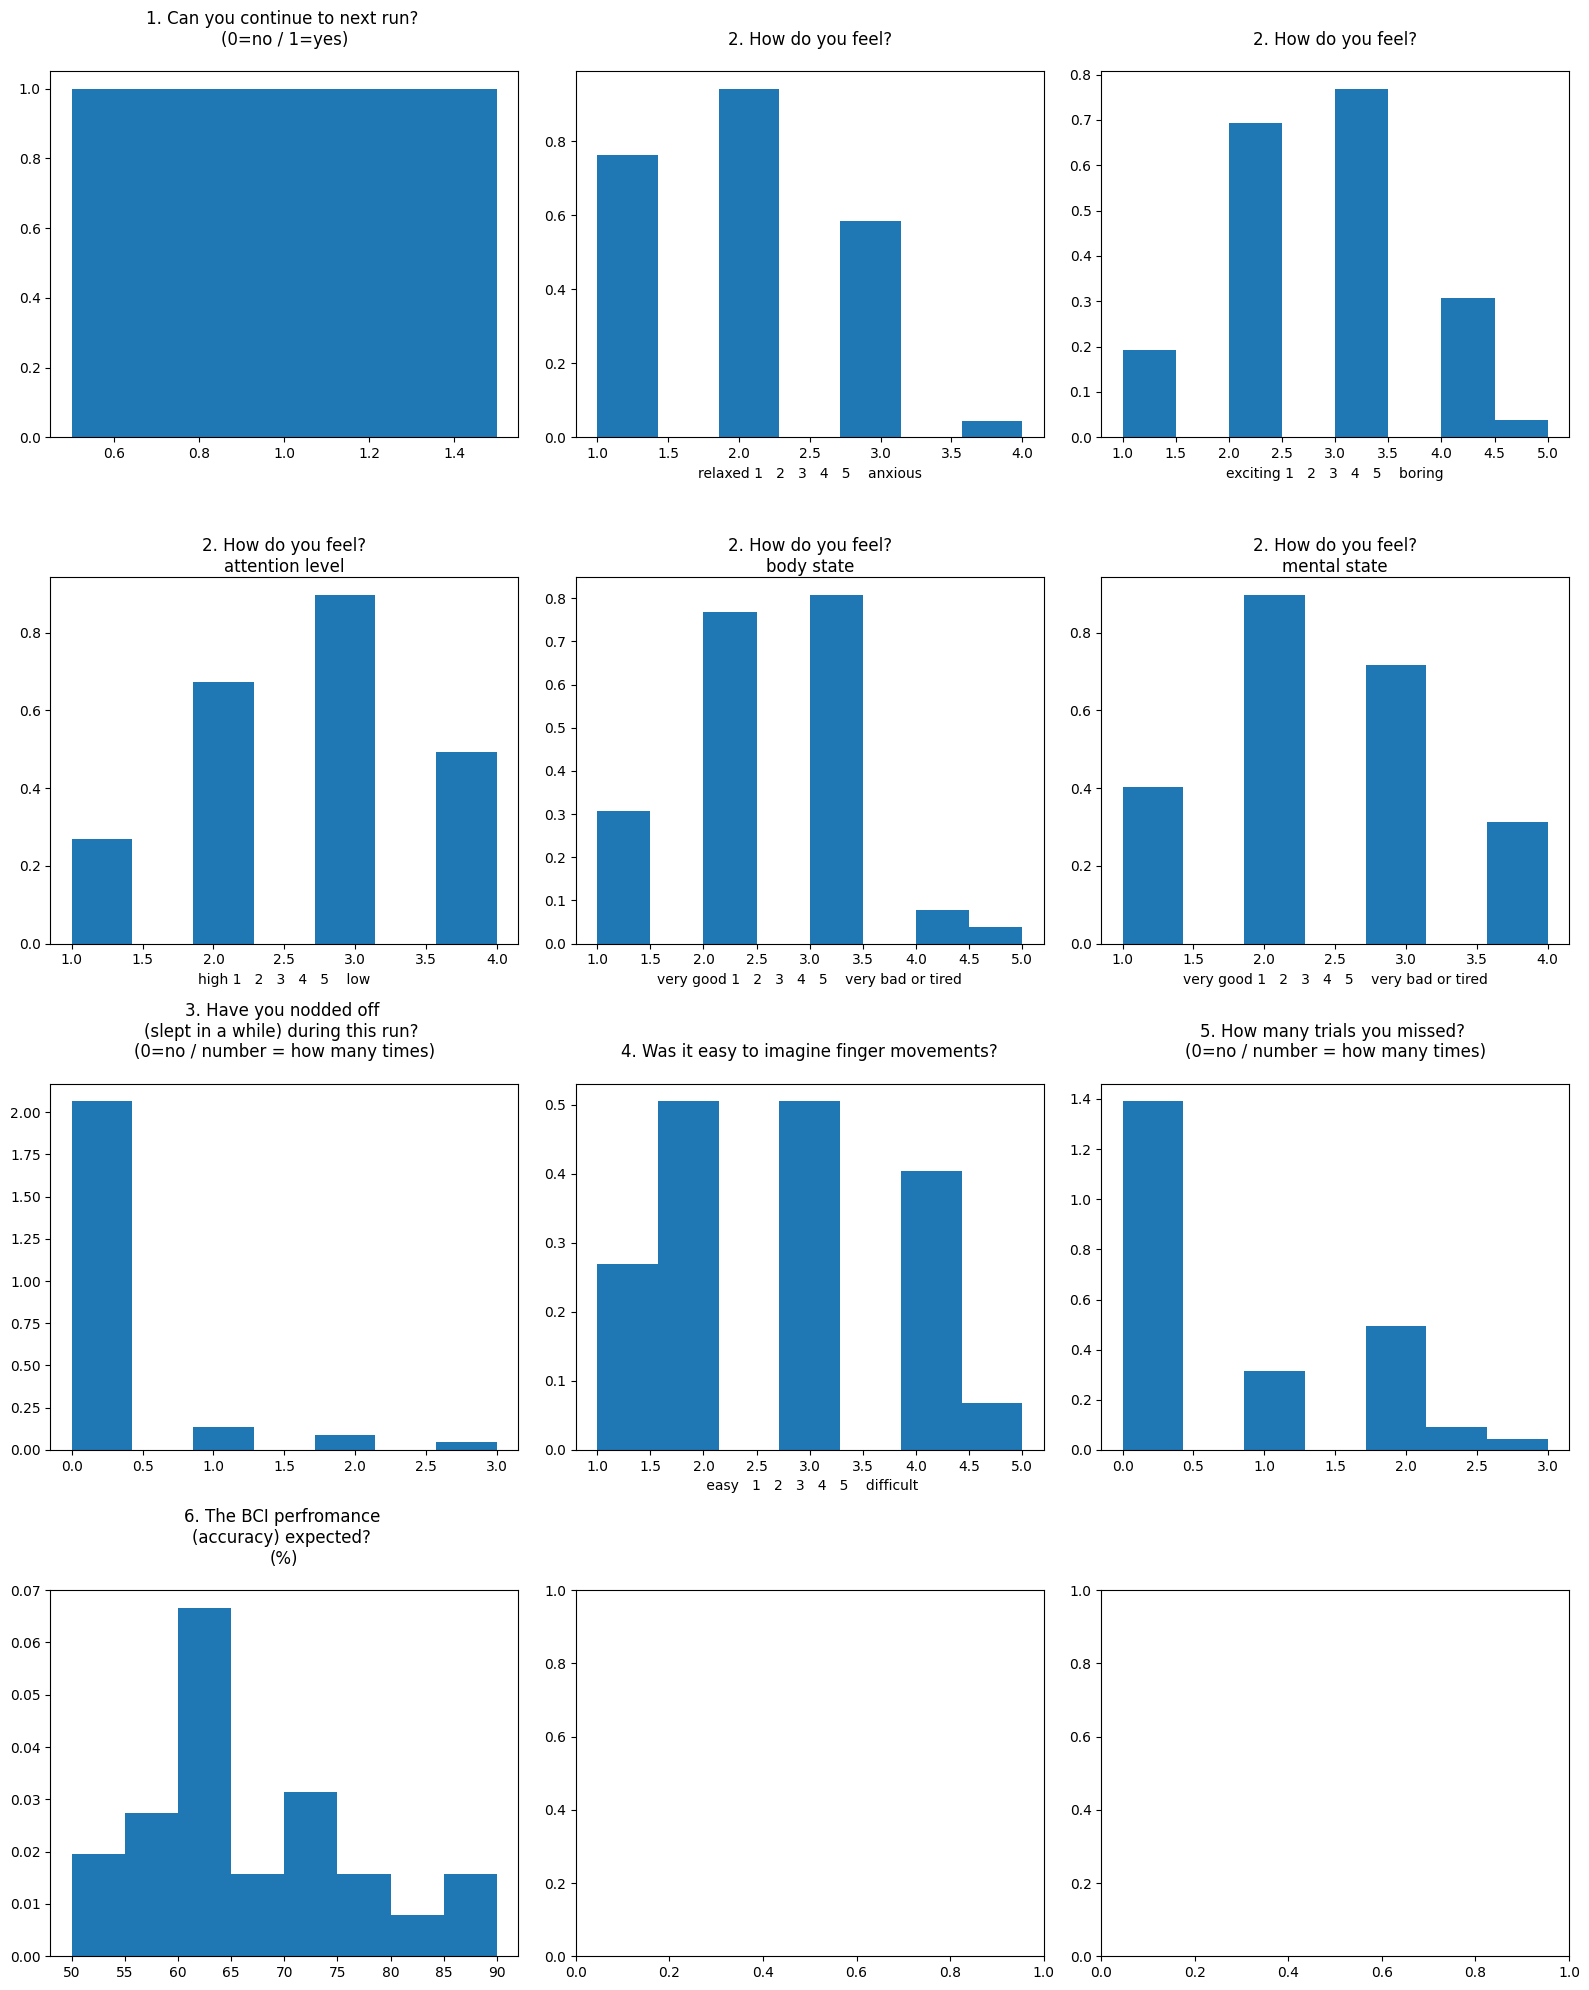

In [22]:
fig, ax = plt.subplots(4, 3, figsize=(16, 20))
df = post_run5
rows = len(df)
for i in range(rows):
    row = int(i/3)
    column = i%3
    if not pandas.isna(df.iloc[i]['Questionaire']):
        title = df.iloc[i]['Questionaire']
    title2 = df.iloc[i]['Unnamed: 3']
    x_label = df.iloc[i]['Unnamed: 4']
    if pandas.isna(x_label):
        x_label=''
    if not pandas.isna(df.iloc[i]["Unnamed: 5"]):
        x_label += f' {df.iloc[i]["Unnamed: 5"]}'
    else:
        x_label = ''
    if pandas.isna(title2):
        title2 = ''
    ax[row][column].set_title(f'{title}\n{title2}'.replace('(', '\n('), wrap=True)
    ax[row][column].set_xlabel(x_label)
    hist_data = ax[row][column].hist(df.iloc[i]['s1':], density=True, bins='auto')
    entropy_ = entropy(hist_data[0])
    entropies += [entropy_]
    if entropy_>=threshold:
        clustering_data += [df.iloc[i]['s1':].values]
        clustering_names += [f'{title} | {x_label}']
fig.tight_layout()
plt.show()

# Post MI

In [23]:
post_mi

,Unnamed: 0,Questionaire,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,s1,s2,s3,...,s43,s44,s45,s46,s47,s48,s49,s50,s51,s52
75,301,1. How was this experiment?,NaN,NaN,Duration,Short 1 2 3 4 5 Long,NaN,3.0,3.0,3.0,...,3.0,3.0,4.0,2.0,4.0,3.0,4.0,3.0,3.0,3.0
76,302,NaN,NaN,NaN,Procedure,Good 1 2 3 4 5 Bad,NaN,1.0,3.0,1.0,...,3.0,2.0,4.0,3.0,4.0,2.0,1.0,1.0,4.0,1.0
77,303,NaN,NaN,NaN,Environment,Comfortable 1 2 3 4 5 Uncomfortable,NaN,1.0,1.0,1.0,...,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,4.0,1.0
78,304,2. The BCI perfromance (accuracy) of whole dat...,NaN,NaN,NaN,NaN,NaN,70.0,60.0,80.0,...,90.0,70.0,60.0,75.0,60.0,70.0,80.0,80.0,60.0,80.0


/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:400: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:401: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.10/site-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


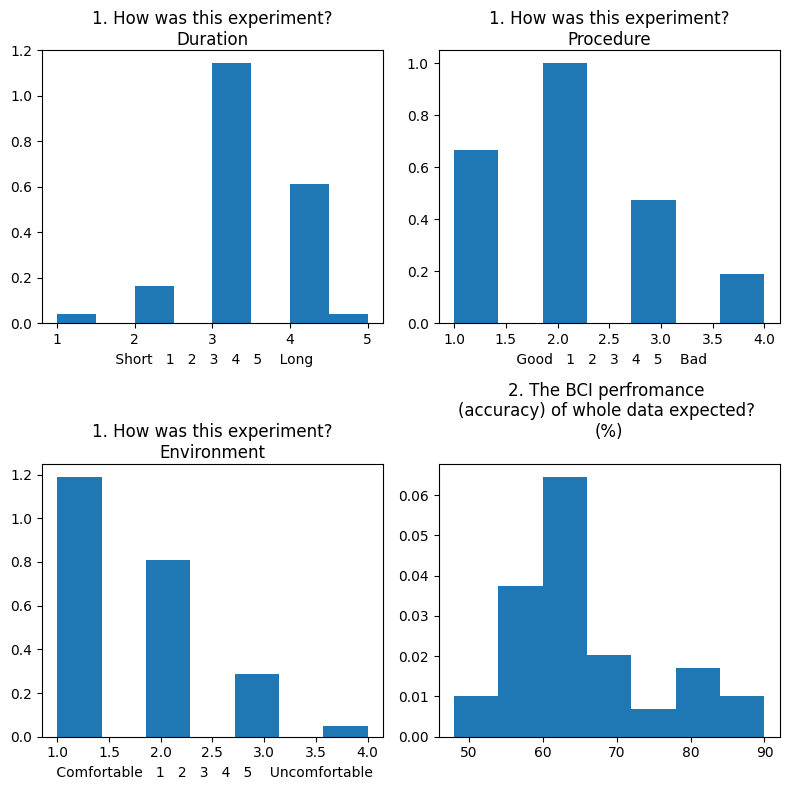

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
df = post_mi
rows = len(df)
for i in range(rows):
    row = int(i/2)
    column = i%2
    if not pandas.isna(df.iloc[i]['Questionaire']):
        title = df.iloc[i]['Questionaire']
    title2 = df.iloc[i]['Unnamed: 4']
    x_label = ""#df.iloc[i]['Unnamed: 4']
    if not pandas.isna(df.iloc[i]["Unnamed: 5"]):
        x_label += f' {df.iloc[i]["Unnamed: 5"]}'
    else:
        x_label = ''
    if pandas.isna(title2):
        title2 = ''
    ax[row][column].set_title(f'{title}\n{title2}'.replace('(', '\n('), wrap=True)
    ax[row][column].set_xlabel(x_label)
    hist_data = ax[row][column].hist(df.iloc[i]['s1':], density=True, bins='auto')
    entropy_ = entropy(hist_data[0])
    entropies += [entropy_]
    if entropy_>=threshold:
        clustering_data += [df.iloc[i]['s1':].values]
        clustering_names += [f'{title} | {x_label}']
fig.tight_layout()
plt.show()

In [25]:
for i in range(len(clustering_data)):
    nans = pandas.isna(clustering_data[i])
    if np.any(nans):
        loc = np.where(nans)[0]
        neg_loc = np.where(nans == False)[0]
        clustering_data[i][loc] = np.mean(clustering_data[i][neg_loc])

In [26]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)

clustering = tsne.fit_transform(np.array(clustering_data, dtype=np.float32).T)

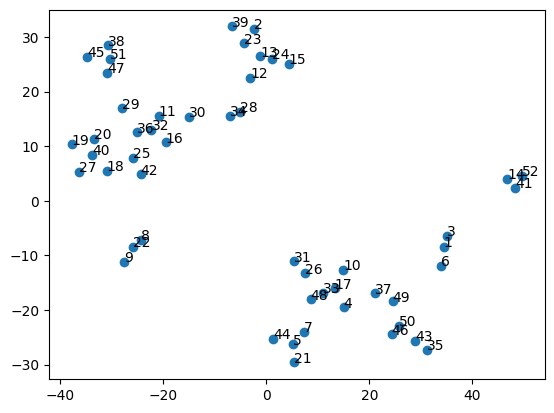

In [27]:
plt.scatter(clustering[:,0], clustering[:,1])
for i in range(52):
    plt.text(clustering[i,0], clustering[i,1], (i+1))
plt.show()

In [ ]:
entropies_array = np.array(entropies)
entropies_array = entropies_array[np.where(entropies_array>=threshold)[0]]

for i,e in zip(clustering_names,entropies_array):
    print(f'{i}\t{e}')

Time slot (1=9:30 / 2=12:30 / 3=15:30 / 4=19:00)	1.3726622424186818
Age(number)	1.7736630326518767
3. How long did you sleep? (1=less than 4h / 2=5~6h / 3=6~7h / 4 = 7~8 / 5= more than 8) | 	1.4849950488871935
4. Did you drink coffee within the past 24 hours (0=no, number=hours before) | 	1.1751952650582613
7. How do you feel? | Relaxed 1   2   3   4   5    Anxious	1.217862466371353
7. How do you feel? | Exciting 1   2   3   4   5    Boring	1.4288758085150772
7. How do you feel? | Very good 1   2   3   4   5    Very bad or tired	1.2909326474879392
7. How do you feel? | Very good 1   2   3   4   5    Very bad or tired	1.2773192428428832
8. The BCI perfromance (accuracy) expected? (%) | 	1.754054195242299
2. How do you feel? | Relaxed 1   2   3   4   5    Anxious	1.1859782264832746
2. How do you feel? | Exciting 1   2   3   4   5    Boring	1.3045086524298783
2. How do you feel? | High 1   2   3   4   5    Low	1.222946730930845
2. How do you feel? | Very good 1   2   3   4   5    Very bad

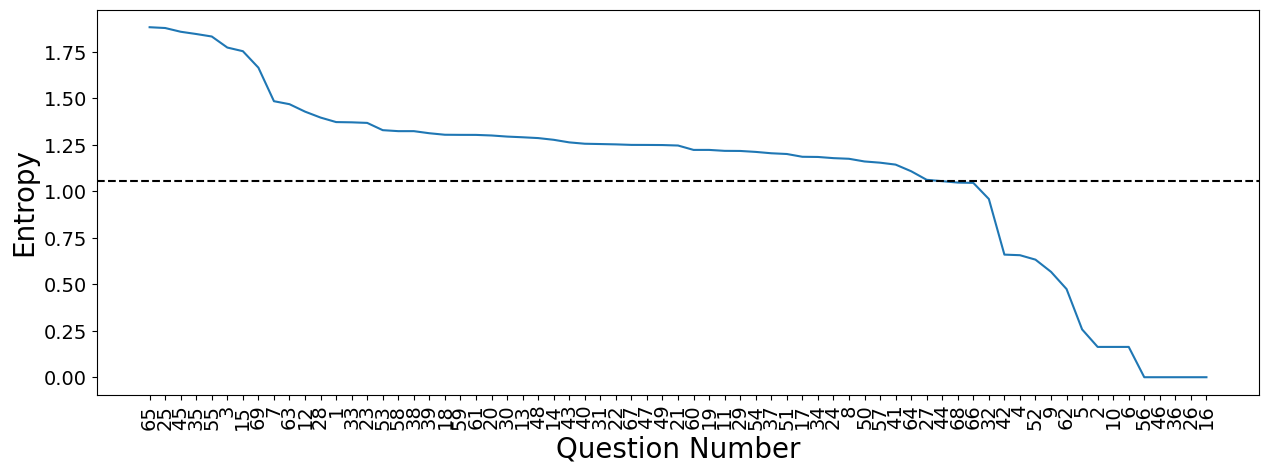

1.0546970453123818

In [36]:
def multi_sort(*args, reverse=True):
    sorted_lists = (list(t) for t in zip(*sorted(zip(*args), reverse=reverse)))
    return tuple(sorted_lists)
num_questions = len(entropies)
sorted_entropies, num = multi_sort(entropies, np.arange(num_questions))
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(num_questions), sorted_entropies)
plt.xticks(np.arange(num_questions)[::1], [x+1 for x in num][::1], size=14, rotation=90)
plt.yticks(size=14)
plt.ylabel('Entropy', size=20)
plt.xlabel('Question Number', size=20)
plt.axhline(np.percentile(entropies, 25), c='black', linestyle='--')
plt.show()
fig.savefig('/kaggle/working/entropies.pdf', bbox_inches='tight')
np.percentile(entropies, 25)

In [ ]:
with open('./clustering_data.npy', 'wb') as f:
    np.save(f, np.array(clustering_data, dtype=np.float32).T,)

with open('./clustering_names.npy', 'wb') as f:
    np.save(f, np.array(clustering_names, dtype=str).T,)

In [ ]:
len(clustering_names), len(clustering_data)

(52, 52)